<a href="https://colab.research.google.com/github/RNEequalRNA/youtube-data-acquisition/blob/main/sample2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import helper
from helper import *

In [ ]:
def reload():
    exec('''__import__('importlib').reload(helper)
from helper import *
    ''')

In [ ]:
# 긍정적, 부정적 단어 데이터셋 불러오기
positiveWords = pd.read_csv('positive.txt')['words']
negativeWords = pd.read_csv('negative.txt')['words']

In [ ]:
videoIdList = retrieve_playlist_videos('PLS3XGZxi7cBVTzEE4Sim9UuNKnUJq9Vkh')  # 플레이리스트에서 처음 50개 영상의 ID 수집

In [ ]:
# API를 통해 비디오의 모든 댓글, 통계 정보(좋아요, 조회수 등)을 수집한다. API 호출 오류를 대비하여 최대 10번까지 재시도한다.
statisticsList = []
commentsList = []
commentsTimestamp = []

for id in videoIdList:
    statisticsList.append(retrieve_statistics(id))
    
    retries = 0
    while True:
        flag = True
        if retries >= 10:
            print("MAX RETRIES REACHED")
            commentsList.append([])
            commentsTimestamp.append([])
            break
        try:
            comment, timestamp = get_comments(id)
            commentsList.append(comment)
            commentsTimestamp.append(timestamp)
        except AssertionError:
            flag = False
            retries += 1
        finally:
            if flag:
                break

In [ ]:
# 데이터 파일로부터 데이터 불러오기
with open('data/videoid.txt', 'r') as f:
    exec(f"videoIdList = {f.read()}")
with open('data/statistics.txt', 'r') as f:
    exec(f"statisticsList = {f.read()}")
with open('data/comments.txt', 'r') as f:
    exec(f"commentsList = {f.read()}")
with open('data/timestamp.txt', 'r') as f:
    exec(f"commentsTimestamp = {f.read()}")

In [ ]:
len(commentsList), sum(map(lambda x: len(x), commentsList))

In [ ]:
allComments = []
for comments in commentsList: allComments += comments

# (단어, 빈도)를 담고 있는 전체 영상에 대한 빈도수 데이터프레임 생성
freqDataFrame = get_freq(allComments)
freqDataFrame

In [ ]:
# 빈도수 데이터프레임을 기반으로 Word Cloud 생성
draw_wordcloud(freqDataFrame)

In [ ]:
words = []
times = []
for i in tqdm(range(len(videoIdList))):
    for j in range(len(commentsList[i])):
        time = parse(commentsTimestamp[i][j]).timestamp()
        
        for word in get_words(commentsList[i][j]):
            words.append(word)
            times.append(time)


# (단어, 단어의 출현 시간(댓글이 작성된 시간))을 담고 있는 데이터프레임 생성
wordtimeDataFrame = pd.DataFrame(columns=['word', 'time'], data={
    'word': words,
    'time': times
})

In [ ]:
PARTITION_SIZE = 15
bins = np.linspace(min(wordtimeDataFrame['time']), max(wordtimeDataFrame['time']), PARTITION_SIZE + 1)  # 수집된 시간의 최소와 최대를 PARTITION_SIZE개의 구간으로 나누기

In [ ]:
for word in freqDataFrame['word'].head(10):  # head 메소드로 가장 빈도수 높은 10개만
    display(wordtimeDataFrame[wordtimeDataFrame['word'] == word].hist(bins=bins))  # 아까 나눈 구간별로 빈도수 히스토그램 그리기
    plt.title(word)

In [ ]:
# timevectorDict[word]는 아까 나눈 word의 구간별 빈도수를 PARTITION_SIZE차원의 벡터로 만들고, 이를 정규화(크기를 1로 만듦)시킨 것
timeVectorDict = dict()
for word in tqdm(freqDataFrame['word'].head(100)):
    timeVectorDict[word] = get_freq_vec(wordtimeDataFrame, word, bins)

In [ ]:
# 코사인 유사도 기반 유사도 데이터프레임 만들기
word1 = []
word2 = []
similarity = []
for w1, v1 in timeVectorDict.items():
    for w2, v2 in timeVectorDict.items():
        if w1 == w2:
            break

        word1.append(w1)
        word2.append(w2)
        similarity.append(np.dot(v1, v2))  # 아까 만든 벡터의 코사인 유사도를 구함

timeSimilarityDataFrame = pd.DataFrame(columns=['word1', 'word2', 'similarity'], data={
    'word1': word1,
    'word2': word2,
    'similarity': similarity
}).sort_values(by='similarity', ascending=False)  # 유사도의 내림차순으로 정렬
timeSimilarityDataFrame[:30]

In [ ]:
freqList = [get_freq(comments) for comments in tqdm(commentsList)]  # freqList[i]는 i번째 영상의 빈도수 데이터프레임

In [ ]:
# tfidfVectorDict[word]는 word의 tf-idf 결과를 (문서 개수)차원의 벡터로 나타낸 것
tfidfVectorDict = dict()
for word in tqdm(freqDataFrame['word'].head(100)):
    tfidfVectorDict[word] = tf_idf(word, freqList)

In [ ]:
# 코사인 유사도 기반 유사도 데이터프레임 만들기
word1 = []
word2 = []
similarity = []
for w1, v1 in tfidfVectorDict.items():
    for w2, v2 in tfidfVectorDict.items():
        if w1 == w2:
            break

        word1.append(w1)
        word2.append(w2)
        similarity.append(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))  # 아까 만든 벡터의 코사인 유사도를 구함

tfidfSimilarityDataFrame = pd.DataFrame(columns=['word1', 'word2', 'similarity'], data={
    'word1': word1,
    'word2': word2,
    'similarity': similarity
}).sort_values(by='similarity', ascending=False)  # 유사도의 내림차순으로 정렬
tfidfSimilarityDataFrame[:30]

In [ ]:
# TSNE(t-Stochastic Neighbor Embedding) 방법을 이용한 시각화
tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

timeVectorArray = np.array([*timeVectorDict.values()])
tfidfVectorArray = np.array([*tfidfVectorDict.values()])

timeVectorArrayEmbedded = tsne.fit_transform(timeVectorArray)
tfidfVectorArrayEmbedded = tsne.fit_transform(tfidfVectorArray)

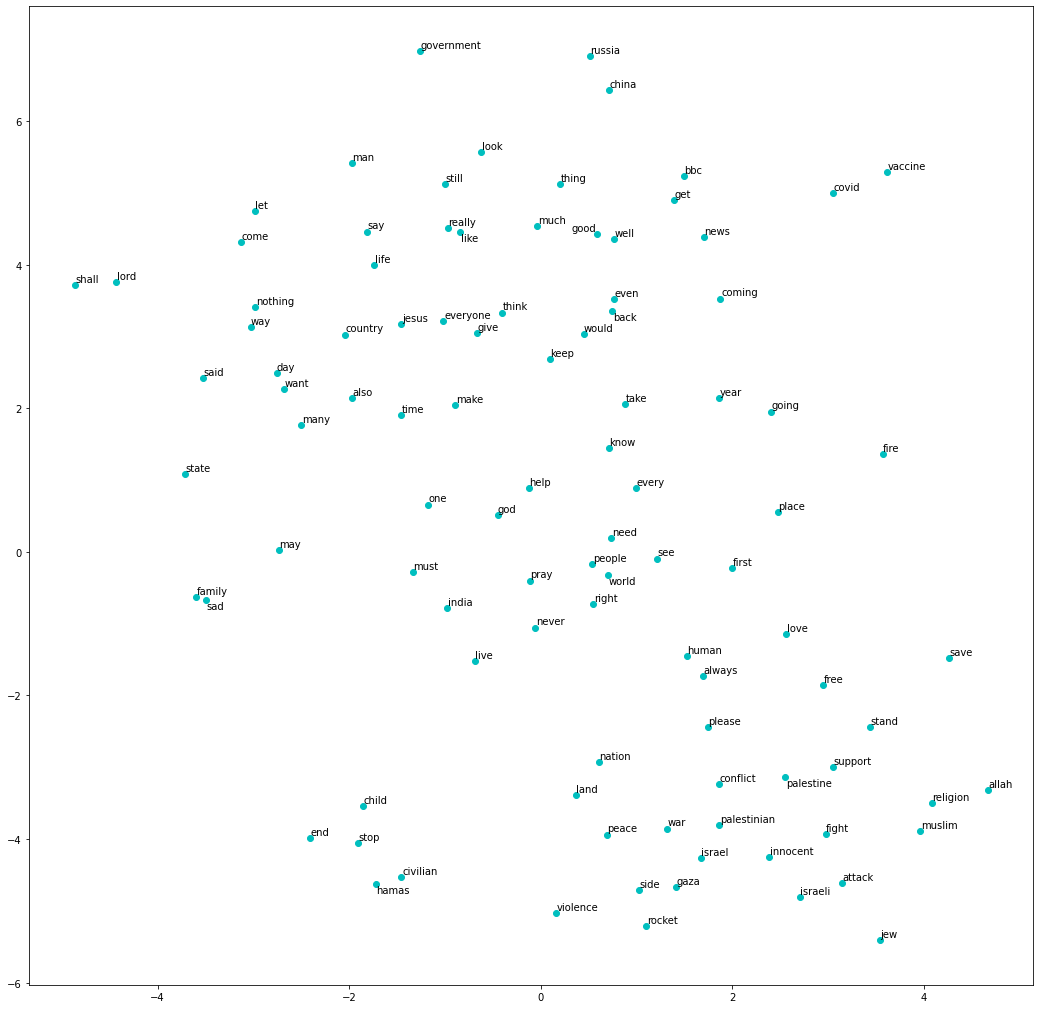

In [81]:
plt.figure(figsize=(18, 18))
plt.scatter(timeVectorArrayEmbedded[:,0], timeVectorArrayEmbedded[:,1], color='c')

texts = []
for index, key in enumerate(timeVectorDict):
    texts.append(plt.text(timeVectorArrayEmbedded[index, 0], timeVectorArrayEmbedded[index, 1], key))
helper.adjust_text(texts)

plt.show()

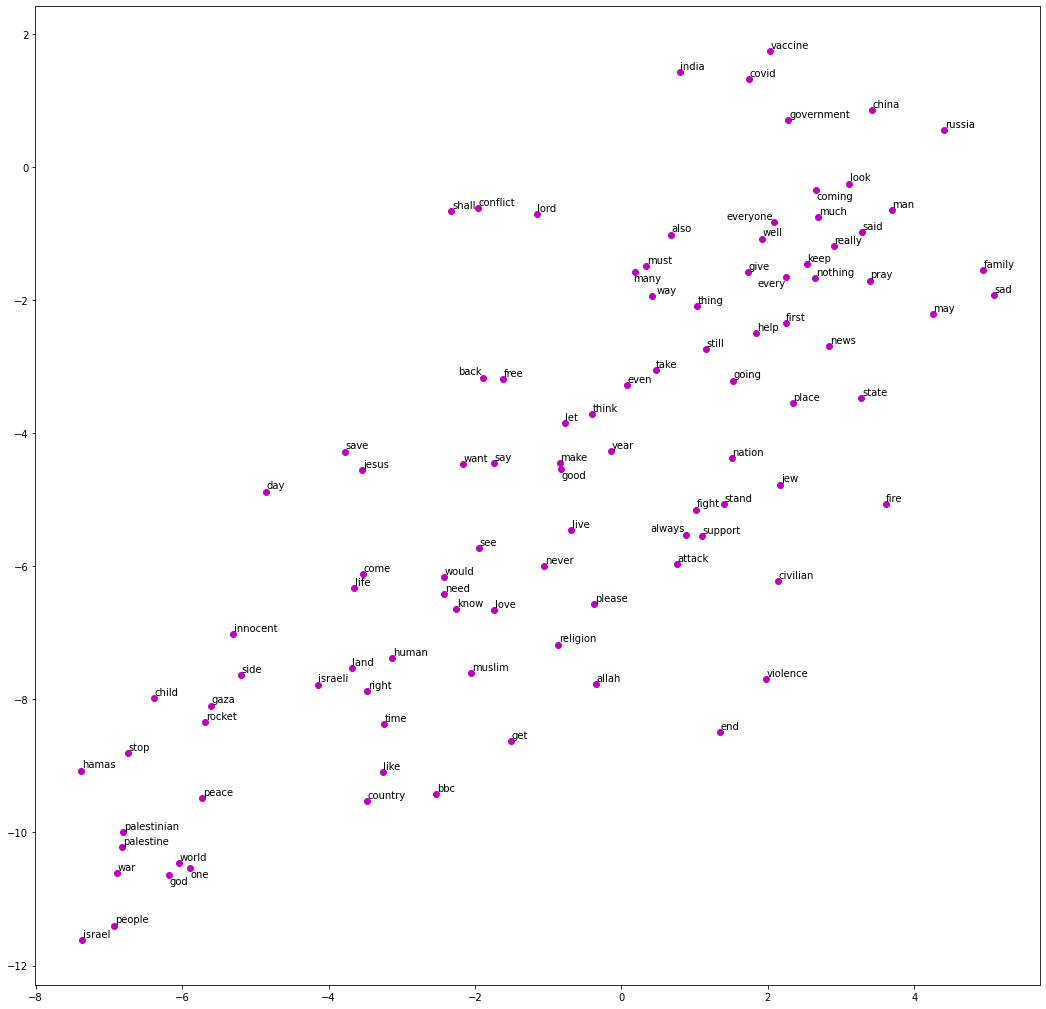

In [82]:
plt.figure(figsize=(18, 18))
plt.scatter(tfidfVectorArrayEmbedded[:,0], tfidfVectorArrayEmbedded[:,1], color='m')

texts = []
for index, key in enumerate(timeVectorDict):
    texts.append(plt.text(tfidfVectorArrayEmbedded[index, 0], tfidfVectorArrayEmbedded[index, 1], key))
helper.adjust_text(texts)

plt.show()

In [ ]:
# 데이터 저장
with open('data/videoid.txt', 'w') as f:
    f.write(str(videoIdList))
with open('data/statistics.txt', 'w') as f:
    f.write(str(statisticsList))
with open('data/comments.txt', 'w') as f:
    f.write(str(commentsList))
with open('data/timestamp.txt', 'w') as f:
    f.write(str(commentsTimestamp))